In [11]:
import torch
from trainer import *
from torch.utils.data import DataLoader
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from models.CNN import *
from sklearn.metrics import r2_score


# Предобработка данных

In [12]:
compr_data_path = r"..\..\data\PDMS\Compression_pdms.csv"
tensl_data_path = r"..\..\data\PDMS\Shear_pdms.csv"
shear_data_path = r"..\..\data\PDMS\Tensile_pdms.csv"
experiments_path = [compr_data_path, tensl_data_path, shear_data_path]

In [13]:
data_frames = [pd.read_csv(file, header=None) for file in experiments_path]
df = pd.concat(data_frames, ignore_index=True)
thinned_data_frames = []
num_points = 50

sampled_df_list = []

for df in data_frames:
    indices = np.linspace(0, len(df) - 1, num_points, dtype=int)
    df[1] = df[1] / 10**4
    sampled_df = pd.DataFrame(df.iloc[indices].copy())
    # print(type(sampled_df))
    sampled_df_list.append(sampled_df)
    # thinned_df = df.iloc[::len(df) // 20, :]  # Выбор каждого 45-го значения
    # thinned_data_frames.append(thinned_df)
data_frames = sampled_df_list

# sampled_df_list[0]


In [14]:
I1_tc = lambda lam: lam ** 2 + 2.0 / lam
I2_tc = lambda lam: 2.0 * lam + 1 / lam ** 2
I1_s = lambda gam: gam ** 2 + 3.0
F_tc = lambda lam: ([lam, 0, 0], [0, lam **(-0.5), 0], [0, 0, lam**(-0.5)])
F_s = lambda gam: ([1., gam, 0], [0, 1., 0], [0, 0, 1.])


In [15]:
mechanical_variables = {
    "I1": [I1_tc, I1_s],
    "I2": [I2_tc, I1_s],
    "F": [F_tc, F_s],
    # "exp_type": [(lambda x: 1), (lambda x: 0)] # 1 - torsion&compression, 0 - shear
    # "torsion_compression": (lambda x: 1)
}

# calculate I1, I2, F from lambda (torsion&compression and shear)
for variable in mechanical_variables.keys():
    func_calc = mechanical_variables.get(variable)

    data_frames[0][variable] = data_frames[0][0].apply(func_calc[0])
    data_frames[1][variable] = data_frames[1][0].apply(func_calc[0])
    data_frames[2][variable]  = data_frames[2][0].apply(func_calc[1])


In [16]:
experiments = ['Compression', 'Tensile', 'Shear']
combined_data = pd.concat([df.assign(Experiment=exp) for df, exp in zip(data_frames, experiments)]).reset_index(drop=True, inplace=False)
combined_data.columns = ['lambda', 'P_experimental', 'I1', 'I2', 'F', 'experiment_type']

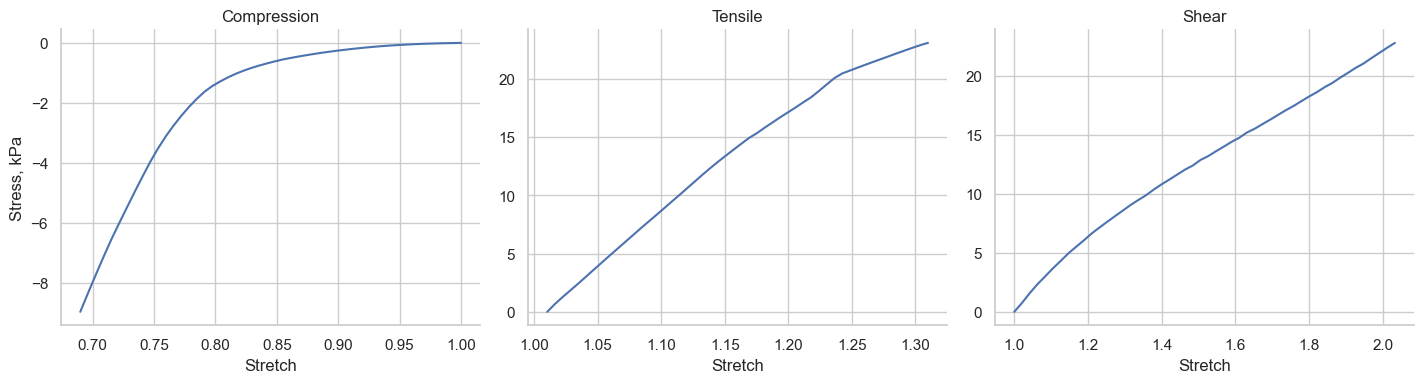

In [17]:
sns.set(style="whitegrid")
g = sns.relplot(
    data=combined_data,
    x='lambda', y='P_experimental', col='experiment_type', kind='line', height=4, aspect=1.2, facet_kws={'sharey': False, 'sharex': False}
)

# Update axis labels
g.set_axis_labels("Stretch", "Stress, kPa")
g.set_titles("{col_name}")
plt.show()

In [18]:
combined_data

,lambda,P_experimental,I1,I2,F,experiment_type
0,0.689936,-8.963625,3.374831,3.480661,"([0.689936, 0, 0], [0, 1.2039143658621678, 0],...",Compression
1,0.696069,-8.356171,3.357790,3.456069,"([0.6960692, 0, 0], [0, 1.1985986696858841, 0]...",Compression
2,0.702543,-7.731957,3.340368,3.431155,"([0.702543, 0, 0], [0, 1.1930634594165739, 0],...",Compression
3,0.708676,-7.149986,3.324385,3.408504,"([0.7086762, 0, 0], [0, 1.1878895891232277, 0]...",Compression
4,0.715150,-6.557265,3.308056,3.385565,"([0.71515, 0, 0], [0, 1.1825007599417483, 0], ...",Compression
...,...,...,...,...,...,...
145,1.947456,21.057000,6.792585,6.792585,"([1.0, 1.947456, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
146,1.968795,21.511000,6.876153,6.876153,"([1.0, 1.9687949, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
147,1.990134,21.954000,6.960633,6.960633,"([1.0, 1.9901338, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
148,2.011473,22.391000,7.046023,7.046023,"([1.0, 2.0114728, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear


In [19]:
from torch.utils.data import DataLoader, random_split, Dataset, TensorDataset
import copy 

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        # self.features = [dataframe[0],dataframe[2], dataframe[3], dataframe[4], dataframe[5]]
        # self.targets  = dataframe[1]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = copy.deepcopy([*self.data.iloc[idx]])
        target = features.pop(1)

        return features, target

    def to_tensor(self):
        for column in self.data.columns[:-1]:
            self.data[column] = self.data[column].apply(
                lambda x: torch.tensor(x, dtype=torch.float32)).copy()


In [20]:
start = 0
end = 49
train_dataset = CustomDataset(combined_data[start:end].copy())
test_dataset = CustomDataset(combined_data.copy())
f, t = train_dataset[0]
lam, i1, i2, F, exp_type = f
print(f)

[0.689936, 3.374831284754612, 3.4806607692906386, ([0.689936, 0, 0], [0, 1.2039143658621678, 0], [0, 0, 1.2039143658621678]), 'Compression']


In [21]:
experiments = ["Shear", "Tensile"]
d = pd.concat([combined_data[combined_data["experiment_type"] == experiment] for experiment in experiments]).reset_index(drop=True, inplace=False)
d

,lambda,P_experimental,I1,I2,F,experiment_type
0,1.000000,0.000000,4.000000,4.000000,"([1.0, 1.0, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
1,1.020280,0.724000,4.040972,4.040972,"([1.0, 1.0202803, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
2,1.041619,1.570000,4.084971,4.084971,"([1.0, 1.0416192, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
3,1.062958,2.341000,4.129880,4.129880,"([1.0, 1.0629581, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
4,1.084297,3.018000,4.175700,4.175700,"([1.0, 1.084297, 0], [0, 1.0, 0], [0, 0, 1.0])",Shear
...,...,...,...,...,...,...
95,1.285386,22.158636,3.208170,3.176019,"([1.2853858, 0, 0], [0, 0.8820297852907864, 0]...",Tensile
96,1.291392,22.389168,3.216409,3.182414,"([1.2913918, 0, 0], [0, 0.8799763245906747, 0]...",Tensile
97,1.297698,22.630807,3.225211,3.189213,"([1.2976981, 0, 0], [0, 0.8778355519819674, 0]...",Tensile
98,1.303704,22.854500,3.233735,3.195767,"([1.3037041, 0, 0], [0, 0.8758111790683766, 0]...",Tensile


In [22]:
def init_loaders(experiments=["Shear", "Tensile", "Comression"]):
    if type(experiments) == str:
        experiments = [experiments]
    print(experiments)
    
    df = pd.concat([combined_data[combined_data["experiment_type"] == experiment] for experiment in experiments]).reset_index(drop=True, inplace=False)
    train_dataset = CustomDataset(df.copy())
    test_dataset = CustomDataset(combined_data.copy())
    
    train_dataset.to_tensor()
    test_dataset.to_tensor()
    
    train_data_loader = DataLoader(
                            train_dataset,
                            shuffle=True,
                            # num_workers=1,
                            pin_memory=False
    )
    test_data_loader = DataLoader(
                            test_dataset,
                            shuffle=False,
                            # num_workers=1,
                            pin_memory=False
    )

    return train_data_loader, test_data_loader 

In [23]:
train_data_loader, test_data_loader = init_loaders("Shear")
train_data_loader.dataset.data

['Shear']


,lambda,P_experimental,I1,I2,F,experiment_type
0,tensor(1.),tensor(0.),tensor(4.),tensor(4.),"[[tensor(1.), tensor(1.), tensor(0.)], [tensor...",Shear
1,tensor(1.0203),tensor(0.7240),tensor(4.0410),tensor(4.0410),"[[tensor(1.), tensor(1.0203), tensor(0.)], [te...",Shear
2,tensor(1.0416),tensor(1.5700),tensor(4.0850),tensor(4.0850),"[[tensor(1.), tensor(1.0416), tensor(0.)], [te...",Shear
3,tensor(1.0630),tensor(2.3410),tensor(4.1299),tensor(4.1299),"[[tensor(1.), tensor(1.0630), tensor(0.)], [te...",Shear
4,tensor(1.0843),tensor(3.0180),tensor(4.1757),tensor(4.1757),"[[tensor(1.), tensor(1.0843), tensor(0.)], [te...",Shear
5,tensor(1.1046),tensor(3.6740),tensor(4.2201),tensor(4.2201),"[[tensor(1.), tensor(1.1046), tensor(0.)], [te...",Shear
6,tensor(1.1259),tensor(4.3120),tensor(4.2677),tensor(4.2677),"[[tensor(1.), tensor(1.1259), tensor(0.)], [te...",Shear
7,tensor(1.1472),tensor(4.9690),tensor(4.3162),tensor(4.3162),"[[tensor(1.), tensor(1.1472), tensor(0.)], [te...",Shear
8,tensor(1.1686),tensor(5.5330),tensor(4.3656),tensor(4.3656),"[[tensor(1.), tensor(1.1686), tensor(0.)], [te...",Shear
9,tensor(1.1889),tensor(6.0590),tensor(4.4134),tensor(4.4134),"[[tensor(1.), tensor(1.1889), tensor(0.)], [te...",Shear


# Обучение модели

In [24]:
experiments=[["Shear", "Tensile", "Comression"],["Tensile", "Comression"], ["Tensile", "Shear"], ["Shear", "Comression"], "Shear", "Tensile", "Comression"]
for experiment in experiments:
    print(experiment)

['Shear', 'Tensile', 'Comression']
['Tensile', 'Comression']
['Tensile', 'Shear']
['Shear', 'Comression']
Shear
Tensile
Comression


In [25]:
# Переименуем столбцы для удобства
# data.columns = ['strain', 'measured_force', 'I1', 'I2', 'F', 'experiment_type', 'predicted_force']

# Удалим ненужные столбцы
# data = data[['strain', 'measured_force', 'experiment_type', 'predicted_force']]
def plot_results(data:pd.DataFrame, plot_name=""):
    # Преобразуем столбец с предсказанной силой в числовой формат
    data['P_model'] = data['P_model'].apply(lambda x: float(str(x).strip('[]')))
    
    # Создадим графики для каждого типа эксперимента
    experiment_types = data['experiment_type'].unique()
    def plot_with_r2(data, experiment_types):
        r2_scores = []
        fig, axes = plt.subplots(1, len(experiment_types), figsize=(15, 6), sharey=True)
        
        for ax, experiment in zip(axes, experiment_types):
            subset = data[data['experiment_type'] == experiment]
            r2 = r2_score(subset['P_experimental'], subset['P_model'])
            
            sns.scatterplot(data=subset, x='lambda', y='P_experimental', label='P_experimental', ax=ax)
            sns.lineplot(data=subset, x='lambda', y='P_model', label='P_model', color='orange', ax=ax)
            ax.set_title(f'Experiment Type: {experiment}\nR² = {r2:.2f}')
            ax.set_xlabel('Strain')
            ax.set_ylabel('Force (kPa)')
            r2_scores.append(r2)
        
        plt.tight_layout()
        plt.show()
        plt.savefig(plot_name)
        return r2_scores
    # Вызовем функцию для построения графиков с r2
    plot_with_r2(data, experiment_types)

In [ ]:
experiments=[["Shear", "Tensile", "Comression"],["Tensile", "Comression"], ["Tensile", "Shear"], ["Shear", "Comression"], "Shear", "Tensile", "Comression"]
for experiment in experiments:
    train_data_loader, test_data_loader = init_loaders(experiment)
    models = [StrainEnergyCANN_C, StrainEnergyCANN_polinomial3]
    train_data_loader, test_data_loader = init_loaders(experiment)

    for model in models:

        name = "PDMS" + str(model.__name__)
        test_train = Trainer(
            plot_valid=False,
            epochs=5000,
            experiment_name=name,
            l2_reg_coeff=0.01,
            learning_rate=0.001,
            checkpoint=None,
            model=model,
            dtype = torch.float64
        )
        
        trained_model = test_train.train(train_data_loader, None, weighting_data=False)
    
        trained_model.eval()
        vpredictions = []
        vtargets = []
        for data in test_data_loader:
            features, target = data
            vpredictions.append(trained_model(features).detach().numpy())
        print(trained_model.get_potential())
        combined_data["P_model"] = vpredictions
        
        plot_results(combined_data, name)
# trained_model = StrainEnergyCANN_C()


# print("R2:", r2_score_own(vtargets, vpredictions))
# plt.figure(figsize=(10, 5))
# plt.plot(vpredictions, label='P_pred', color='red')
# plt.plot(vtargets, label='P_true', color='black')
# plt.xlabel('lambda/gamma')
# plt.ylabel('P')
# plt.title('Predictions vs. Targets')
# plt.legend()

# plt.show()

['Shear', 'Tensile', 'Comression']
['Shear', 'Tensile', 'Comression']
Directory pretrained_models\PDMSStrainEnergyCANN_C already exists

Epoch [1/5000], Loss: 204.38903650, Test metric: 204.38903650
psi =   0.01 * (I1 - 3) \\               + 0.11 * (e^{  0.12 * (I1 - 3)} - 1)\\               - 0.11 * ln(1 - 0.12 * (I1 - 3)) \\               + 0.01 * (I1 - 3) ^ 2 \\               + 0.09 * (e^{  0.08 * (I1 - 3) ^ 2} - 1)\\               - 0.11 * ln(1 - 0.11 * (I1 - 3) ^ 2) \\                               + 0.01 * (I2 - 3) \\               + 0.11 * (e^{  0.11 * (I2 - 3))} - 1)\\               - 0.08* ln(1 - 0.11 *  (I2 - 3)) \\               + 0.01 * (I2 - 3) ^ 2 \\               + 0.10 * (e^{  0.08 *(I2 - 3) ^ 2)} - 1)\\               - 0.11* ln(1 - 0.11 * (I2 - 3) ^ 2)\\

Epoch [2/5000], Loss: 160.04866649, Test metric: 160.04866649
psi =   0.05 * (I1 - 3) \\               + 0.21 * (e^{  0.22 * (I1 - 3)} - 1)\\               - 0.21 * ln(1 - 0.22 * (I1 - 3)) \\               + 0.03 * (I

In [ ]:
best_model_path = r"C:\Users\drani\dd\data-driven-constitutive-modelling\src\CANN_torch\pretrained_models\PDMS_full\20240522_1718_533.pth"
trained_model = StrainEnergyCANN_polinomial3()
trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    vpredictions.append(trained_model(features).detach().numpy())
print(trained_model.get_potential())
combined_data["P_model"] = vpredictions

plot_results(combined_data)

In [ ]:
best_model_path = r"C:\Users\drani\dd\data-driven-constitutive-modelling\src\CANN_torch\pretrained_models\PDMS_6term\20240522_1851_466.pth"
trained_model = StrainEnergyCANN_C()
trained_model.load_state_dict(torch.load(best_model_path))
trained_model.eval()
vpredictions = []
vtargets = []
for data in test_data_loader:
    features, target = data
    vpredictions.append(trained_model(features).detach().numpy())
print(trained_model.get_potential())
combined_data["P_model"] = vpredictions

plot_results(combined_data)